In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-30 16:35:31.239899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


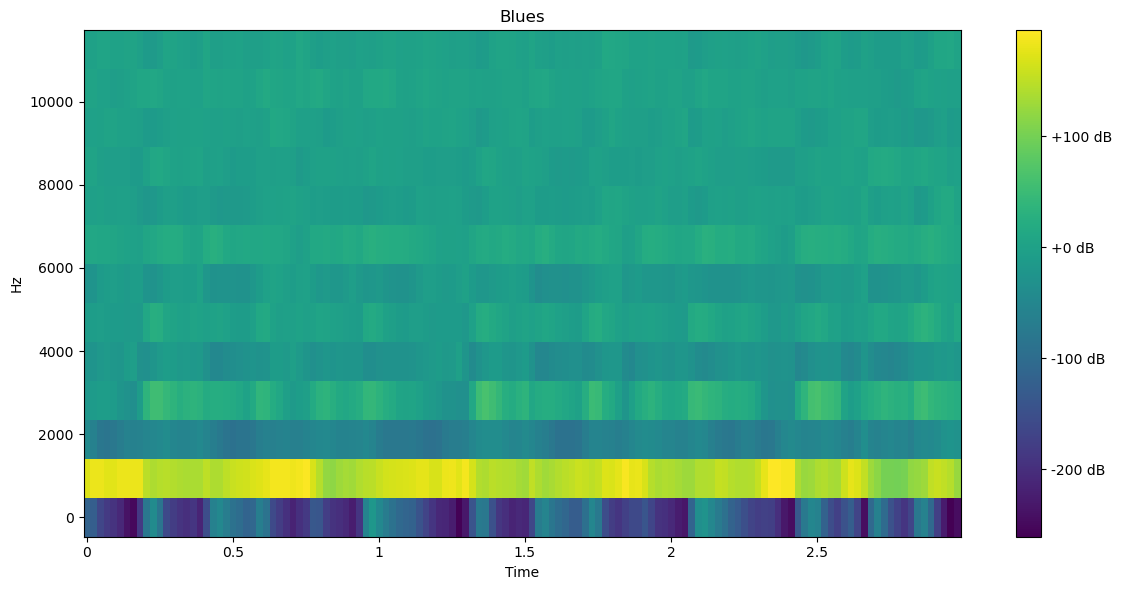

In [3]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_3.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [9]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (5593, 132, 13), y training data shape: (5593,)
X validation data shape: (1399, 132, 13), y validation data shape: (1399,)


In [10]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
print("a", X_train_cnn.shape)
print("a", X_test_cnn.shape)
print("a", input_shape)

model_cnn1 = Sequential()

model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

model_cnn1.add(Dense(10, activation='softmax')) 

model_cnn1.summary()


a (5593, 132, 13, 1)
a (2997, 132, 13, 1)
a (132, 13, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 130, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 65, 6, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 63, 4, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 1, 64)         16448     
                                                               

In [11]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
88/88 [==============================] - 2s 22ms/step - loss: 2.8732 - acc: 0.2331 - val_loss: 1.9004 - val_acc: 0.3438
Epoch 2/250
88/88 [==============================] - 2s 21ms/step - loss: 1.8115 - acc: 0.3740 - val_loss: 1.6696 - val_acc: 0.4017
Epoch 3/250
88/88 [==============================] - 2s 21ms/step - loss: 1.6233 - acc: 0.4264 - val_loss: 1.5563 - val_acc: 0.4289
Epoch 4/250
88/88 [==============================] - 2s 20ms/step - loss: 1.5177 - acc: 0.4591 - val_loss: 1.4840 - val_acc: 0.4532
Epoch 5/250
88/88 [==============================] - 2s 21ms/step - loss: 1.4096 - acc: 0.4922 - val_loss: 1.3950 - val_acc: 0.4939
Epoch 6/250
88/88 [==============================] - 2s 20ms/step - loss: 1.3468 - acc: 0.5140 - val_loss: 1.3566 - val_acc: 0.5061
Epoch 7/250
88/88 [==============================] - 2s 20ms/step - loss: 1.2749 - acc: 0.5450 - val_loss: 1.3159 - val_acc: 0.5125
Epoch 8/250
88/88 [==============================] - 2s 21ms/step - loss: 1.

94/94 [==============================] - 0s 3ms/step - loss: 2.0502 - acc: 0.7040
Test Loss: 2.050234079360962
Test Accuracy: 0.7040373682975769


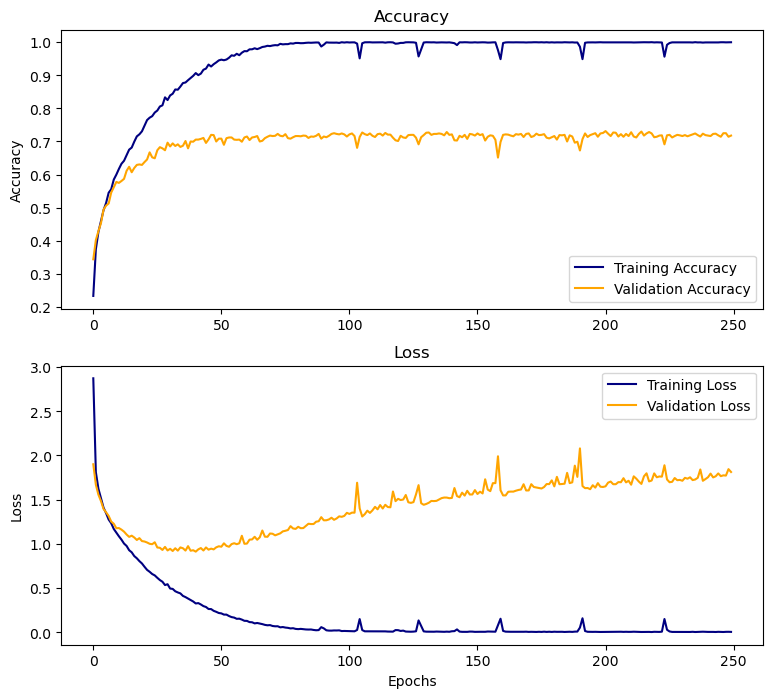

In [12]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

plot_history(hist_cnn1)

In [13]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(10, activation='softmax'))

model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 130, 11, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 130, 11, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 65, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 65, 6, 32)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 63, 4, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (None, 63, 4, 64)       

In [14]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
88/88 [==============================] - 3s 35ms/step - loss: 3.1090 - acc: 0.1677 - val_loss: 2.1232 - val_acc: 0.2645
Epoch 2/250
88/88 [==============================] - 3s 35ms/step - loss: 2.3868 - acc: 0.2614 - val_loss: 1.8503 - val_acc: 0.3374
Epoch 3/250
88/88 [==============================] - 3s 34ms/step - loss: 2.0929 - acc: 0.3190 - val_loss: 1.6714 - val_acc: 0.4096
Epoch 4/250
88/88 [==============================] - 3s 34ms/step - loss: 1.9318 - acc: 0.3492 - val_loss: 1.5914 - val_acc: 0.4425
Epoch 5/250
88/88 [==============================] - 3s 34ms/step - loss: 1.8215 - acc: 0.3771 - val_loss: 1.5787 - val_acc: 0.4317
Epoch 6/250
88/88 [==============================] - 3s 34ms/step - loss: 1.7259 - acc: 0.4089 - val_loss: 1.5837 - val_acc: 0.4396
Epoch 7/250
88/88 [==============================] - 3s 35ms/step - loss: 1.6497 - acc: 0.4288 - val_loss: 1.5711 - val_acc: 0.4539
Epoch 8/250
88/88 [==============================] - 3s 36ms/step - loss: 1.

94/94 [==============================] - 0s 4ms/step - loss: 0.7274 - acc: 0.8075
Test Loss: 0.7274096012115479
Test Accuracy: 0.8074741363525391


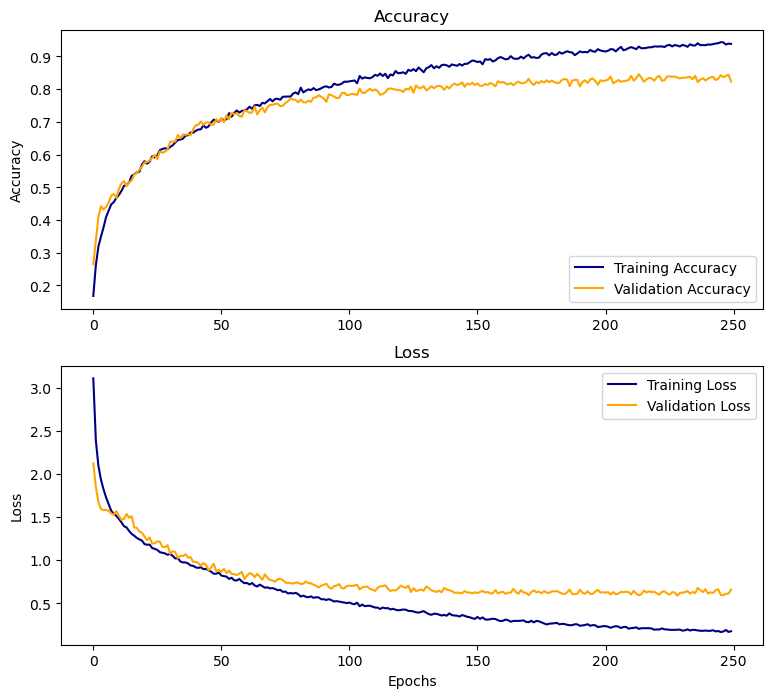

In [15]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

plot_history(hist_cnn2)

In [16]:
from tensorflow.python.keras.layers import RepeatVector
from tensorflow.python.keras.regularizers import l1

model_cnn3 = Sequential()
# Conv Block 1
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn3.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())

# 2nd conv layer
model_cnn3.add(Conv2D(64, (3, 3), activation='relu',
                                   kernel_initializer='he_uniform',
                                   kernel_regularizer=l2(0.0001)))
model_cnn3.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# 3rd conv layer
model_cnn3.add(Conv2D(128, (2, 2), activation='relu',
                                   kernel_initializer='he_uniform',
                                   kernel_regularizer=l2(0.0001)))
model_cnn3.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# Flatten and Dense layer
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu',
                                  kernel_initializer='he_uniform',
                                  kernel_regularizer=l2(0.0001)))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# Output layer
model_cnn3.add(Dense(10, activation='softmax'))

model_cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 130, 11, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 65, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 65, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 63, 4, 64)         18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 2, 64)        0         
 g2D)                                                            
                                                      

In [17]:
datagen = ImageDataGenerator(vertical_flip=True)

callbacks = [
             EarlyStopping(patience=10)
]

model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
175/175 [==============================] - 3s 15ms/step - loss: 2.4357 - acc: 0.2791 - val_loss: 1.7006 - val_acc: 0.4139
Epoch 2/100
175/175 [==============================] - 3s 14ms/step - loss: 1.9478 - acc: 0.3867 - val_loss: 1.3817 - val_acc: 0.5239
Epoch 3/100
175/175 [==============================] - 3s 14ms/step - loss: 1.7455 - acc: 0.4380 - val_loss: 1.3098 - val_acc: 0.5568
Epoch 4/100
175/175 [==============================] - 3s 14ms/step - loss: 1.6192 - acc: 0.4670 - val_loss: 1.2332 - val_acc: 0.5726
Epoch 5/100
175/175 [==============================] - 3s 14ms/step - loss: 1.5071 - acc: 0.5033 - val_loss: 1.1828 - val_acc: 0.6011
Epoch 6/100
175/175 [==============================] - 3s 14ms/step - loss: 1.4496 - acc: 0.5214 - val_loss: 1.1652 - val_acc: 0.6011
Epoch 7/100
175/175 [==============================] - 3s 15ms/step - loss: 1.3729 - acc: 0.5400 - val_loss: 1.1325 - val_acc: 0.6219
Epoch 8/100
175/175 [==============================] - 3s 15ms

94/94 [==============================] - 0s 3ms/step - loss: 0.6401 - acc: 0.8005
Test Loss: 0.6401406526565552
Test Accuracy: 0.8004671335220337


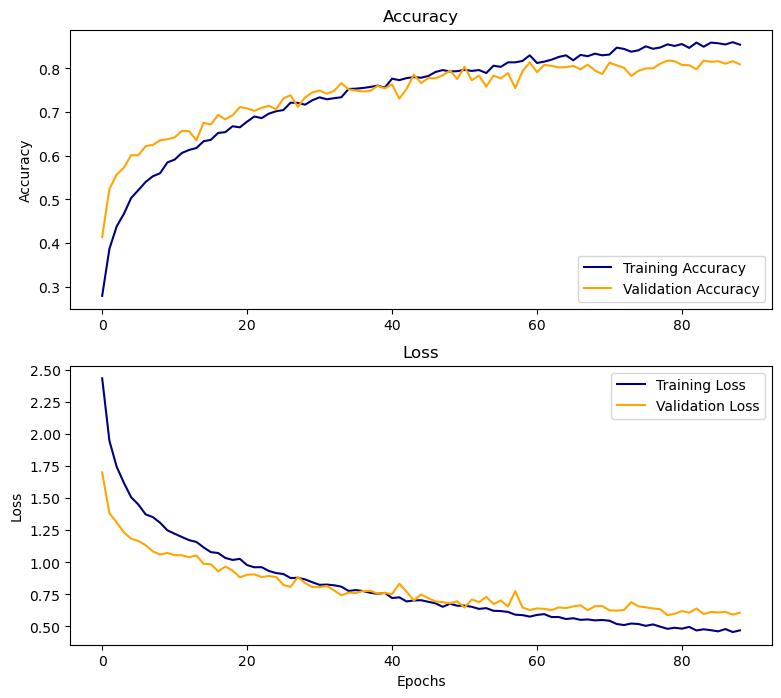

In [18]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

plot_history(hist_cnn3)

In [21]:
preds_num, preds_name = make_prediction(model_cnn2, X_test)

1/1 [==============================] - 0s 11ms/step


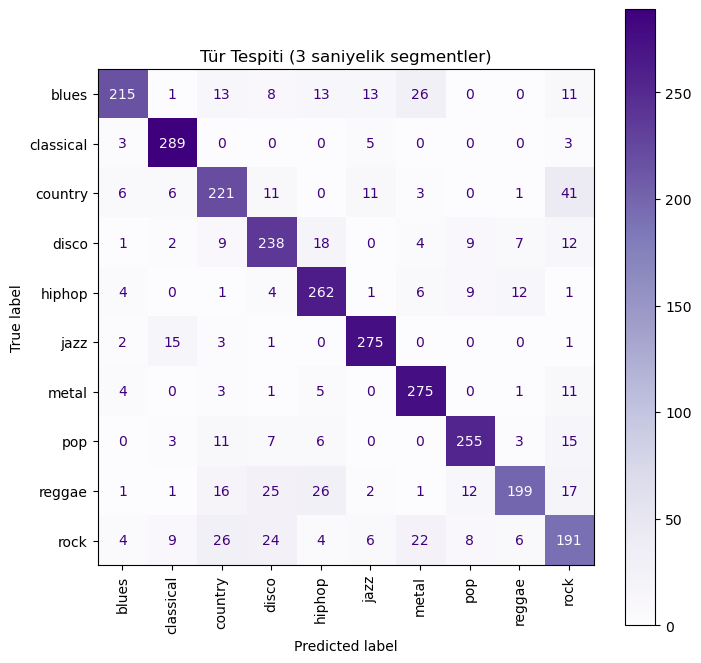

In [22]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [23]:
preds_num, preds_name = make_prediction(model_cnn3, X_test)

1/1 [==============================] - 0s 11ms/step


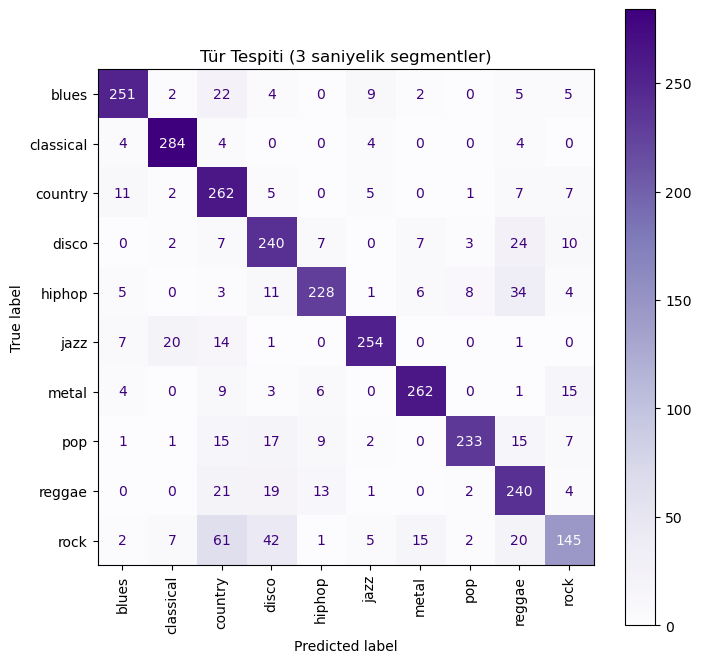

In [24]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');

In [10]:
model_cnn2.save(os.path.join(path_prefix, "models/model_cnn.h5"))

In [25]:
model_cnn3.save(os.path.join(path_prefix, "models/model_cnn.h5"))
model_cnn3.save(os.path.join(path_prefix, "models/model_cnn.keras"), save_format="keras")

In [26]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

def evaluate_model(model, X, y_true):
    global genres
    # Tahminleri al
    preds_num, _ = make_prediction(model, X)

    # Genel skorlar
    accuracy = accuracy_score(y_true, preds_num)
    precision_macro = precision_score(y_true, preds_num, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, preds_num, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, preds_num, average='macro')
    f1_weighted = f1_score(y_true, preds_num, average='weighted')

    # Genel sonuçları yazdır
    print("🔹 Genel Performans:")
    print(f"Accuracy               : {accuracy:.4f}")
    print(f"Precision (macro)      : {precision_macro:.4f}")
    print(f"Precision (weighted)   : {precision_weighted:.4f}")
    print(f"F1 Score (macro)       : {f1_macro:.4f}")
    print(f"F1 Score (weighted)    : {f1_weighted:.4f}")

    # Sınıf bazlı skorlar
    print("\n🔹 Tür Bazlı Performans (Precision, Recall, F1):")
    report = classification_report(y_true, preds_num, target_names=genres, zero_division=0)
    print(report)

    # Dictionary olarak da döndür
    return classification_report(y_true, preds_num, target_names=genres, output_dict=True, zero_division=0)


metrics = evaluate_model(model_cnn3, X_test, y_test)

1/1 [==============================] - 0s 11ms/step
🔹 Genel Performans:
Accuracy               : 0.8005
Precision (macro)      : 0.8123
Precision (weighted)   : 0.8122
F1 Score (macro)       : 0.7997
F1 Score (weighted)    : 0.7996

🔹 Tür Bazlı Performans (Precision, Recall, F1):
              precision    recall  f1-score   support

       blues       0.88      0.84      0.86       300
   classical       0.89      0.95      0.92       300
     country       0.63      0.87      0.73       300
       disco       0.70      0.80      0.75       300
      hiphop       0.86      0.76      0.81       300
        jazz       0.90      0.86      0.88       297
       metal       0.90      0.87      0.89       300
         pop       0.94      0.78      0.85       300
      reggae       0.68      0.80      0.74       300
        rock       0.74      0.48      0.58       300

    accuracy                           0.80      2997
   macro avg       0.81      0.80      0.80      2997
weighted avg   

In [8]:
import math
import numpy as np
import librosa
import tensorflow as tf

model = tf.keras.models.load_model(path_prefix + "/models/model_cnn.h5")

def load_and_pad_audio(audio_file, sample_rate=22500, target_duration=30):
    signal, sr = librosa.load(audio_file, sr=sample_rate)
    total_duration = librosa.get_duration(y=signal, sr=sr)

    target_length = sample_rate * target_duration  # örn. 30 saniye
    full_segments = int(np.ceil(total_duration / target_duration))

    padded_signal = []

    for i in range(full_segments):
        start = int(i * target_length)
        end = int((i + 1) * target_length)
        segment = signal[start:end]

        if len(segment) < target_length:
            # Padding with zeros to reach 30s
            padding = np.zeros(int(target_length - len(segment)))
            segment = np.concatenate((segment, padding))

        padded_signal.append(segment)

    return padded_signal, sr

def extract_mfcc_segments(segment, sr, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    samples_per_segment = int(len(segment) / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    print(num_mfcc_vectors_per_segment)

    mfccs = []
    for d in range(num_segments):
        start = samples_per_segment * d
        finish = start + samples_per_segment

        mfcc = librosa.feature.mfcc(
            y=segment[start:finish],
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mfcc=num_mfcc
        )
        mfcc = mfcc.T
        if mfcc.shape[0] == num_mfcc_vectors_per_segment:
            mfccs.append(mfcc)

    return np.array(mfccs)

audio_path = path_prefix + "/test_tracks/sample9.wav"
segments, sr = load_and_pad_audio(audio_path, sample_rate=22500, target_duration=30)

all_mfcc_segments = []

for segment in segments:
    mfcc_segments = extract_mfcc_segments(segment, sr)
    all_mfcc_segments.extend(mfcc_segments)

segment_predictions = []
for mfcc_segment in all_mfcc_segments:
    X = mfcc_segment[np.newaxis, ..., np.newaxis]
    prediction = model.predict(X)
    segment_predictions.append(prediction[0])

average_prediction = np.mean(segment_predictions, axis=0)

genre_dict = {
    0: "blues", 1: "classical", 2: "country", 3: "disco", 4: "hiphop",
    5: "jazz", 6: "metal", 7: "pop", 8: "reggae", 9: "rock"
}

for i, percent in enumerate(average_prediction * 100):
    print(f"{genre_dict[i]:<10}: {percent:.2f}%")

predicted_index = np.argmax(average_prediction)
print("\n🎵 Predicted Genre:", genre_dict[int(predicted_index)])


132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
132
1/1 [==============================] - 0s 14ms/step
blues     : 0.41%
classical : 80.11%
country   : 1.77%
disco     : 0.21%
hiphop    : 0.87%
jazz      : 8.38%
metal     : 0.03%
pop       : 1.77%
reggae    : 5.53%
rock      : 0.93%

🎵 Predicted Genre: classical
